# This Notebook is for analyzing and processing the output of scrap

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [74]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Variables

In [249]:
all_links_path = '../data/raw/all_links.json'
all_jobs_details_path = 'data/raw/all_jobs_detail.json'
all_dirty_data_path = '../data/raw/colect_all_job_dirty_data_slow_all.json'

# Functions

In [240]:
def clean_column_strings(df):
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x[0]).replace('\n','').strip())
    
    return df

# Loading data

In [44]:
with open(all_links_path, 'r') as openfile:
        #Reading from json file
        all_links = json.load(openfile)

In [45]:
with open(all_jobs_details_path, 'r') as openfile:
        #Reading from json file
        data_job = json.load(openfile)

In [250]:
with open(all_dirty_data_path, 'r') as openfile:
        #Reading from json file
        durty_data_job = json.load(openfile)

# Wrangle data experiments

### Logic for capture job ids in urls

In [31]:
all_links[0]['links']

['https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/senior-data-scientist-kpm-p3723-at-84-51%CB%9A-3314238897?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=KHI3nickYQBR7OeopQDj3g%3D%3D&position=2&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/lead-data-scientist-p3719-at-84-51%CB%9A-3314239209?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=zcJINMCFRhLTJRmOCyGqhw%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-developer-productivity-at-stem-inc-3377674000?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=kAhiDeiBwGKMhhlRVAY9og%3D%3D&position=4&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'https://www.linkedin.com/jobs/view/software-engineer-big-data-at-pinterest-3453

In [32]:
all_links[0]['links'][0]

'https://www.linkedin.com/jobs/view/senior-data-scientist-at-tala-3338538962?refId=6JEIwkKj0uJkzXjxYSFliA%3D%3D&trackingId=itkVQcypfASexZhU95Tt5g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card'

In [33]:
unique_link = all_links[0]['links'][0]

In [34]:
# It will work, considering that every Job id will always have ten characters
re.findall(r'\d{10}', unique_link)[0]

'3338538962'

In [35]:
#capturing all Job Ids in url
all_ids = []
for l in all_links[0]['links']:
    unique_id = re.findall(r'\d{10}', l)[0]
    all_ids.append(unique_id)

In [36]:
all_ids

['3338538962',
 '3314238897',
 '3314239209',
 '3377674000',
 '3453529654',
 '3314238949',
 '3314236535',
 '3453526797',
 '3314238945',
 '3314239198',
 '3314239195',
 '3314233697',
 '3458419440',
 '3452289200',
 '3451507215',
 '3215796936',
 '3459196895',
 '3453567797',
 '3439168848',
 '2925991336',
 '3403509733',
 '3405457294',
 '3390029031',
 '3344168805',
 '3439171495']

### Clean durty data

In [251]:
df_job = pd.json_normalize(durty_data_job)

In [252]:
df_job = clean_column_strings(df_job)

# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [253]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link
0,Sr. Data Scientist,"Hershey, PA",PRI Global,Sr. Data Scientist,Mid-Senior level,Contract,Engineering and Information Technology,IT Services and IT Consulting,Job DescriptionSummary:The Enterprise Data Sci...,https://www.linkedin.com/jobs/view/3478366331
1,Full Stack Java Developer,"Columbia, SC",SPECTRAFORCE,Full Stack Java Developer,Mid-Senior level,Contract,Information Technology,Staffing and Recruiting,Job Title: Full Stack Java DeveloperLocation: ...,https://www.linkedin.com/jobs/view/3478344435
2,Senior Full Stack Developer,United States,Optomi,Senior Full Stack Developer,Mid-Senior level,Contract,Information Technology and Engineering,"IT Services and IT Consulting, Computer Hardwa...",Senior Full Stack Developer (Angular/Java/AWS)...,https://www.linkedin.com/jobs/view/3471538079
3,UI Developer,United States,eTeam,UI Developer,Mid-Senior level,Contract,Finance and Sales,Staffing and Recruiting,Job Title: UI Developer Duration: 08+ Months+ ...,https://www.linkedin.com/jobs/view/3475030934
4,Software Engineer II,"Minneapolis, MN",Maxonic,Software Engineer II,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Maxonic is supporting our direct client to ful...,https://www.linkedin.com/jobs/view/3468540882
...,...,...,...,...,...,...,...,...,...,...
442,Remote Genesys Developer,United States,Insight Global,Remote Genesys Developer,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting and Banking,Position: Remote Genesys DeveloperLocation: Re...,https://www.linkedin.com/jobs/view/3469095218
443,Senior Scala Developer,United States,American Technology Consulting - ATC,Senior Scala Developer,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Title: Senior Software EngineerLocation: Urban...,https://www.linkedin.com/jobs/view/3467841735
444,ETL Developer - Informatica,United States,Planet Technology,ETL Developer - Informatica,Mid-Senior level,Contract,Information Technology,Insurance,6 months remote contractSkills7+ Years of expe...,https://www.linkedin.com/jobs/view/3472301962
445,Sr .Net Developer - Remote Work,United States,"TWO95 International, Inc",Sr .Net Developer - Remote Work,Mid-Senior level,Contract,Information Technology,IT Services and IT Consulting,Title : Sr .Net DeveloperLocation : Remote Wor...,https://www.linkedin.com/jobs/view/3471548555


In [254]:
df_job.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                447 non-null    object
 1   location             447 non-null    object
 2   company_name         447 non-null    object
 3   position_name        447 non-null    object
 4   experience_required  447 non-null    object
 5   contract_type        447 non-null    object
 6   function_name        447 non-null    object
 7   company_sector       447 non-null    object
 8   description          447 non-null    object
 9   link                 447 non-null    object
dtypes: object(10)
memory usage: 35.0+ KB


In [255]:
df_job.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Contract: Senior iOS Developer              17
Contract: Senior Backend Engineer (Perl)     7
Javascript Developer                         4
Dotnet Developer                             4
Software Engineer                            3
Sr Salesforce Developer                      3
Senior Machine Learning Engineer             3
Python Developer                             3
Senior Software Engineer                     3
Data Engineer                                3
Name: position_name, dtype: int64

Top 10 Titles offered  
High diversity title job for the same position

<AxesSubplot:xlabel='title', ylabel='position_name'>

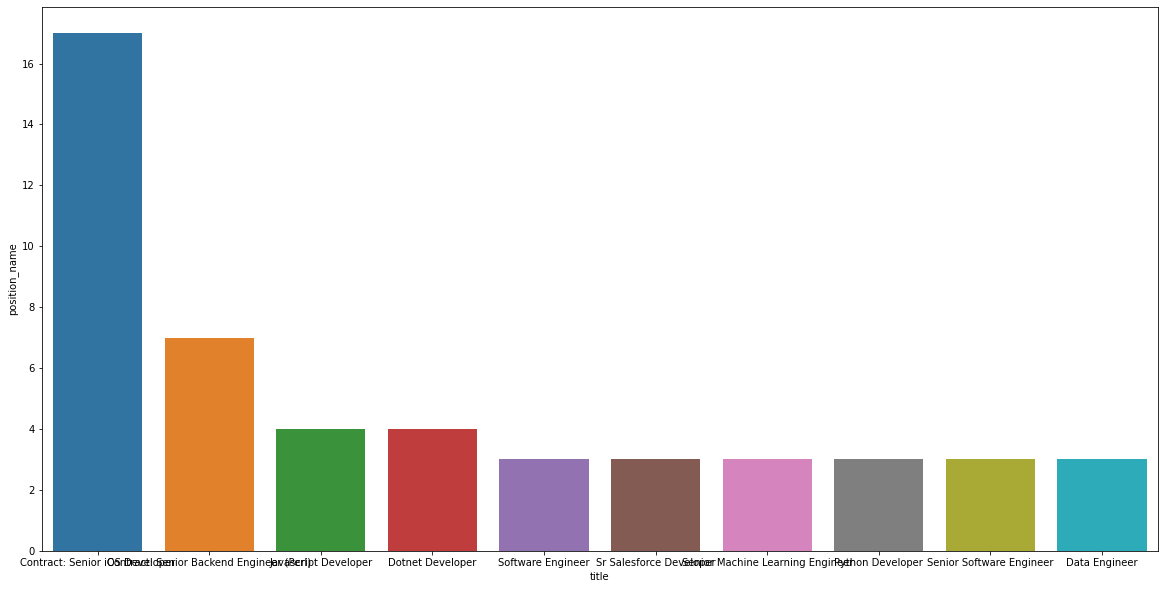

In [256]:
top_10_jobs_name = df_job.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)

Experiences required

In [257]:
df_job.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    447
Name: title, dtype: int64

All contract type

In [258]:
df_job.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Contract     439
Temporary      8
Name: title, dtype: int64

All different Function names

In [259]:
df_job.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Engineering and Information Technology                               206
Information Technology                                               147
Information Technology and Engineering                                14
Research, Analyst, and Information Technology                          7
Engineering                                                            6
Project Management and Information Technology                          5
Other                                                                  3
Information Technology and Analyst                                     3
Accounting/Auditing and Finance                                        2
Design, Art/Creative, and Information Technology                       2
Research                                                               2
Quality Assurance                                                      2
Management and Manufacturing                                           2
Finance and Sales                    

All different company sectors

In [260]:
df_job.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
IT Services and IT Consulting                                                                       121
Technology, Information and Internet                                                                 87
Staffing and Recruiting                                                                              64
Technology, Information and Internet and Human Resources Services                                    24
Software Development                                                                                 12
                                                                                                   ... 
IT Services and IT Consulting, Software Development, and Computers and Electronics Manufacturing      1
IT Services and IT Consulting, Software Development, and Hospitality                                  1
IT Services and IT Consulting, Software Development, and Research Services                            1
IT Services and IT Consulting, Staffing and Recru

All different locations

In [261]:
df_job.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                        233
California, United States              9
Jacksonville, FL                       6
New York, NY                           6
Chicago, IL                            6
                                    ... 
Idaho, United States                   1
Hershey, PA                            1
Hartford, CT                           1
Greater Minneapolis-St. Paul Area      1
Wisconsin, United States               1
Name: title, Length: 112, dtype: int64

Example of description

In [87]:
df_job['description'][0]

'Job Details:Title: Data ScientistLocation: RemoteDuration: 6 Months Contract (Only on W2) Required Skills:· 3-5 years of experience· Apply knowledge of machine learning techniques and concepts, including the design and implementation of advanced artificial intelligence, computational algorithms, and data science techniques.· Participate in and lead the running of experiments and documentation of results in technical or research whitepapers.· Communicates data findings to both business and IT leaders to influence how an organization approaches and meets business challenges of an evolving customer base and changing marketplace, using strong business acumen.· Collaborates with database engineers and other scientists to develop, refine, and scale data management and analytics procedures, systems, workflows, best practices, and other issues.· Conduct statistical modeling and experiment design, test and validate predictive models.· Conducts scalable data research, on and off the cloud.· Dev